# Forecasting Mini-Course Sales with Gradient Boosting Frameworks

**AIM**: To predict 2022 sales data for various fictitious learning modules from different fictitious Kaggle-branded stores in different countries with sales data pertaining to 2017-2021.

### Step 1: Importing Libraries & Examining the Data

In [1]:
#!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:0031m11.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.2
    Uninstalling pip-22.0.2:
      Successfully uninstalled pip-22.0.2


In [2]:
#!apt-get install -y python-opengl
#!apt install xvfb -y

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
#!pip install -q pycaret
#!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/18/99/054dc6abe6d706a20cf31dc48a8d3de7b1601a44343def3f512f84e94f97/shap-0.42.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [4]:
#!pip install holidays

  Obtaining dependency information for holidays from https://files.pythonhosted.org/packages/c7/60/88807b94b2d32617b9c01b6ae6500f4a0e2fecfadf8e597c9eef1319a113/holidays-0.29-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.7/695.7 kB 6.4 MB/s eta 0:00:007.3 MB/s eta 0:00:01


In [5]:
#!pip install --force-reinstall --no-deps numpy==1.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 17.0 MB/s eta 0:00:00m eta 0:00:01:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.21.0-cp310-cp310-linux_x86_64.whl size=19528847 sha256=b92138413853200e9562590a79bbab2b4e5df1c69ccc2379533116c5bc7476f8
  Stored in directory: /home/leanne/.cache/pip/wheels/05/61/d1/ccc2cd557b39e127ad98a392d9558f3c5dda28764b7f54b2f5
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [3]:
# Importing libraries
!pip install seaborn
!pip install catboost
!pip install xgboost
!pip install lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import holidays
from pycaret.regression import setup, compare_models 
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform as randFloat
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [4]:
# Reading in the data while parsing the 'date' column in as a datetime dtype
orig_train = pd.read_csv('train.csv', parse_dates = ['date'])
orig_test = pd.read_csv('test.csv', parse_dates = ['date'])

# Looking at the training data
orig_train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [5]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.3+ MB


In [6]:
orig_train.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


We'll take a look at the monthly sales per year next

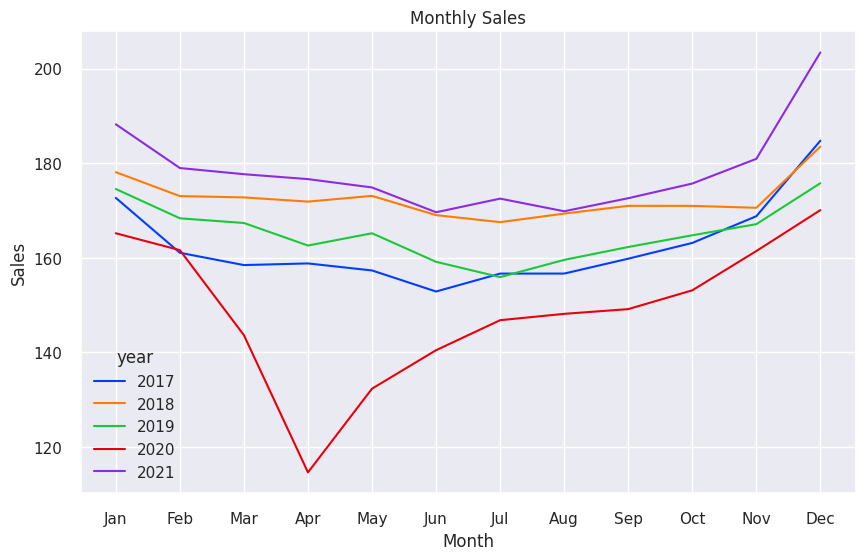

In [7]:
monthly_sales = orig_train.copy()
monthly_sales['year'] = monthly_sales['date'].dt.year
monthly_sales['month'] = monthly_sales['date'].dt.month

grouped_data = monthly_sales.groupby(['year', 'month'])['num_sold'].sum().reset_index()

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='num_sold', hue='year', ax=ax, errorbar=None, palette='bright')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales')
plt.show()

We can notice a significant drop in sales around the time of Covid (April 2020). This will impact our final model performance and so we'll adjust these values in a later step.

In [8]:
orig_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       27375 non-null  int64         
 1   date     27375 non-null  datetime64[ns]
 2   country  27375 non-null  object        
 3   store    27375 non-null  object        
 4   product  27375 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.0+ MB


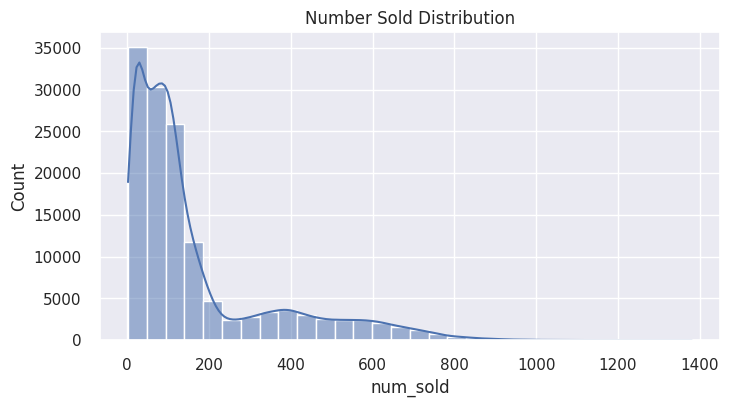

In [9]:
# Plotting a distribution of target variable, num_sold
plt.figure(figsize=(8,4))
sns.histplot(orig_train['num_sold'], color='b', bins=30, kde=True)
plt.title('Number Sold Distribution')

plt.show()

The target variable distribution is stongly right-skewed, later we'll use a log transformation to amend this.

### Initial Observations:
- Our train and test sets contain a mix of categorical and numerical data.
- Our target variable is strongly right-skewed
- There is a significant drop in sales around the time of Covid (April 2020)

### Covid Sales 

In [10]:
monthly_sales_amended = monthly_sales.copy()

april_adjust = (monthly_sales_amended['year'] == 2020) & (monthly_sales_amended['month'] == 4)
adjustment_factor_april = 1.2
monthly_sales_amended.loc[april_adjust, 'num_sold'] *= adjustment_factor_april

may_adjust = (monthly_sales_amended['year'] == 2020) & (monthly_sales_amended['month'] == 5)
adjustment_factor_may = 1.05
monthly_sales_amended.loc[may_adjust, 'num_sold'] *= adjustment_factor_may

monthly_sales_amended

,id,date,country,store,product,num_sold,year,month
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0,2017,1
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0,2017,1
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0,2017,1
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0,2017,1
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0,2017,1
...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700.0,2021,12
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752.0,2021,12
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111.0,2021,12
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641.0,2021,12


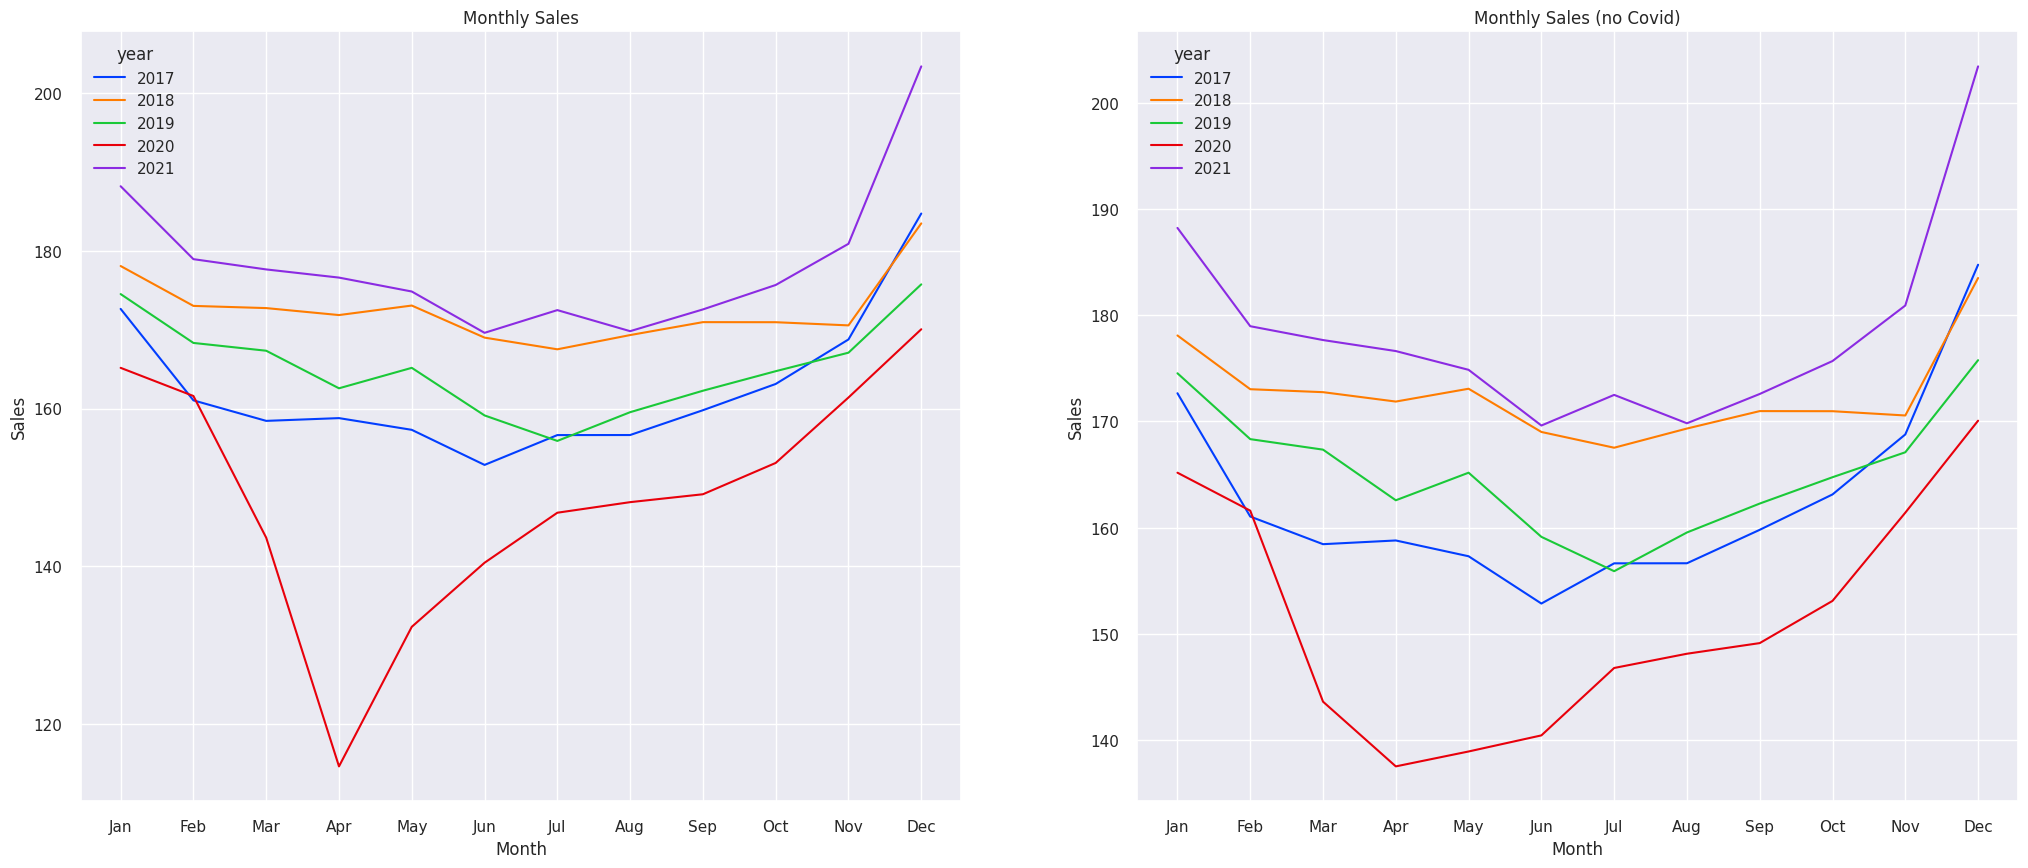

In [11]:
plt.figure(figsize=(25, 10))

# Original Data
plt.subplot(1, 2, 1)
grouped_data = monthly_sales.groupby(['year', 'month'])['num_sold'].sum().reset_index()

sns.set(style="darkgrid")
ax = sns.lineplot(data=monthly_sales, x='month', y='num_sold', hue='year', errorbar=None, palette='bright')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales')

# Amended Data
plt.subplot(1, 2, 2)
grouped_data = monthly_sales.groupby(['year', 'month'])['num_sold'].sum().reset_index()

sns.set(style="darkgrid")
ax = sns.lineplot(data=monthly_sales_amended, x='month', y='num_sold', hue='year', errorbar=None, palette='bright')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly Sales (no Covid)')

plt.show()


We'll continue by using the adjusted values for the covid period sales.

In [12]:
train_clean = orig_train.copy()

In [13]:
def covid_adjustment(row):
    april_adjustment_factor = 1.2
    may_adjustment_factor = 1.05
    if row['date'].year == 2020:
        if row['date'].month == 4:  # April
            return row['num_sold'] * april_adjustment_factor
        elif row['date'].month == 5:  # May
            return row['num_sold'] * may_adjustment_factor
        else:
            return row['num_sold']
    else:
        return row['num_sold']

# Apply the adjustments to the num_sold column in the train_clean df
train_clean['num_sold'] = train_clean.apply(covid_adjustment, axis=1)

## Step 2: Combining Train & Test Datasets

We'll combine both our datasets before performing transformations on our categorical and numeric data.

In [14]:
# Combining the data

# Isolating the target variable 
target_var = train_clean['num_sold']

# Isolating the Id column - it isn't needed in the analysis but is for testing the predictions 
ids = orig_test['id']

# Dropping target_var and ids from the datasets

new_train = train_clean.drop(['id','num_sold'],axis=1)
new_test = orig_test.drop('id',axis=1)

# Creating a new df with the combined data
combined_data = pd.concat([new_train, new_test], axis=0).reset_index(drop=True)

combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164325 entries, 0 to 164324
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     164325 non-null  datetime64[ns]
 1   country  164325 non-null  object        
 2   store    164325 non-null  object        
 3   product  164325 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 5.0+ MB


## Step 3: Identifying Holidays & Weekends

Holidays and weekends are known to have an impact on the sales of many products around the world. To get the most from our model we will identify and highlight these time periods.

In [15]:
# Extracting datetime objects from our date column
combined_data['year'] = combined_data['date'].dt.year
combined_data['month'] = combined_data['date'].dt.month
combined_data['day'] = combined_data['date'].dt.day
combined_data['dayofweek'] = combined_data.date.dt.dayofweek

In [16]:
# Identifying weekends
combined_data['is_weekend'] = combined_data['date'].dt.dayofweek.isin([5, 6]).astype(int)

In [17]:
# Identifying holidays
country_names = ['Argentina','Spain','Estonia','Japan','Canada']
# Creating a blank df to hold all country holiday info
holiday_df = pd.DataFrame()

# Iterating through country_names and creating a dataframe for each country's holidays
for country in country_names:
    country_hols = pd.DataFrame(holidays.country_holidays(country,years=range(2017,2023)).items(), columns=['date', 'name'])
    country_hols['country'] = country
    # Appending each country's holiday df to the holiday_df
    holiday_df = pd.concat([holiday_df,country_hols],axis=0, ignore_index=True)
    
# Converting date column from object to dt for merge    
holiday_df['date'] = pd.to_datetime(holiday_df['date'])

# Merging the dataframes using a left join, this way we'll keep only those dates that are holidays
combined_final = combined_data.merge(holiday_df[['date','country']], on=['date','country'],how='left', indicator=True)

# Adding a holiday column that indicates if the day is a holiday
combined_final['holiday'] = combined_final['_merge'].apply(lambda x: 1 if x=='both' else 0)
combined_final = combined_final.drop(columns='_merge', axis=1)

combined_final = combined_final[['date','country','store','product','year','month','day','dayofweek','is_weekend','holiday']]
combined_final

,date,country,store,product,year,month,day,dayofweek,is_weekend,holiday
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2017,1,1,6,1,1
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2017,1,1,6,1,1
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2017,1,1,6,1,1
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2017,1,1,6,1,1
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,2017,1,1,6,1,1
...,...,...,...,...,...,...,...,...,...,...
164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,5,1,0
164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,5,1,0
164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,5,1,0
164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,5,1,0


In [18]:
combined_final_df = combined_final.copy()

# Isolating our country names before we transform the country column
combined_final_df['country_name'] = combined_final['country']

## Feature Transformations

In [19]:
# Encoding Categorical Columns
le = LabelEncoder()

combined_final_df['store'] = le.fit_transform(combined_final_df['store'])
combined_final_df['product'] = le.fit_transform(combined_final_df['product'])
combined_final_df['country'] = le.fit_transform(combined_final_df['country'])

In [20]:
# Transforming cyclic features - month and day 
def day_month_transformer(df):
    df['month_cos'] = df['month'].apply(lambda x: np.cos(x / 12 * 2 * np.pi))
    df['day_sin'] = df['day'].apply(lambda x: np.sin(x / 365 * 2 * np.pi))
    df['day_cos'] = df['day'].apply(lambda x: np.cos(x / 365 * 2 * np.pi))
    return df

combined_final_df = day_month_transformer(combined_final_df)

combined_final_df

,date,country,store,product,year,month,day,dayofweek,is_weekend,holiday,country_name,month_cos,day_sin,day_cos
0,2017-01-01,0,1,0,2017,1,1,6,1,1,Argentina,0.866025,0.017213,0.999852
1,2017-01-01,0,1,1,2017,1,1,6,1,1,Argentina,0.866025,0.017213,0.999852
2,2017-01-01,0,1,2,2017,1,1,6,1,1,Argentina,0.866025,0.017213,0.999852
3,2017-01-01,0,1,3,2017,1,1,6,1,1,Argentina,0.866025,0.017213,0.999852
4,2017-01-01,0,1,4,2017,1,1,6,1,1,Argentina,0.866025,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164320,2022-12-31,4,0,0,2022,12,31,5,1,0,Spain,1.000000,0.508671,0.860961
164321,2022-12-31,4,0,1,2022,12,31,5,1,0,Spain,1.000000,0.508671,0.860961
164322,2022-12-31,4,0,2,2022,12,31,5,1,0,Spain,1.000000,0.508671,0.860961
164323,2022-12-31,4,0,3,2022,12,31,5,1,0,Spain,1.000000,0.508671,0.860961


## Step 4: Transforming the Target Variable

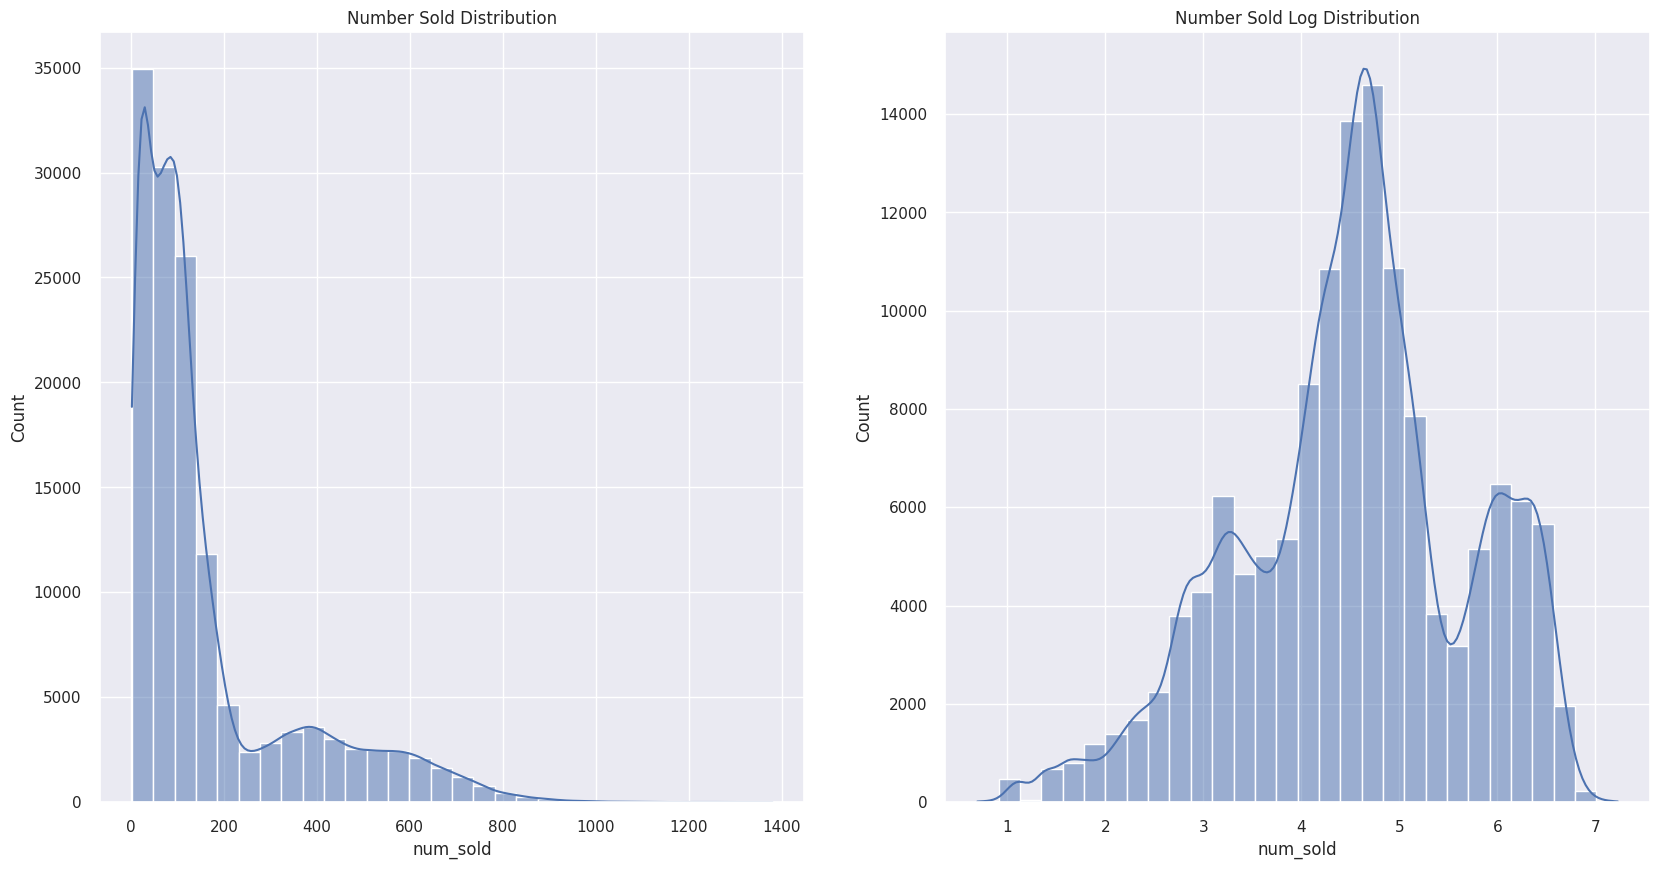

In [21]:
# Transforming the target varible with logs

log_target_var = np.log(train_clean['num_sold']) 

# Plotting the new log distribution of target variable against the original
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(target_var, color='b', bins=30, kde=True)
plt.title('Number Sold Distribution')

plt.subplot(1,2,2)
sns.histplot(log_target_var, color='b', bins=30, kde=True)
plt.title('Number Sold Log Distribution')

plt.show()

We now have a much better distribution of our target varible and will use this log version going forward.

## Step 5: Splitting the Data
Now, we'll split the data back into the original training and test sets.

In [22]:
final_train = combined_final_df.iloc[:136950,:]
final_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          136950 non-null  datetime64[ns]
 1   country       136950 non-null  int64         
 2   store         136950 non-null  int64         
 3   product       136950 non-null  int64         
 4   year          136950 non-null  int64         
 5   month         136950 non-null  int64         
 6   day           136950 non-null  int64         
 7   dayofweek     136950 non-null  int64         
 8   is_weekend    136950 non-null  int64         
 9   holiday       136950 non-null  int64         
 10  country_name  136950 non-null  object        
 11  month_cos     136950 non-null  float64       
 12  day_sin       136950 non-null  float64       
 13  day_cos       136950 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(9), object(1)
memory usage: 

In [23]:
final_test = combined_final_df.iloc[136950:,:].reset_index(drop=True)
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          27375 non-null  datetime64[ns]
 1   country       27375 non-null  int64         
 2   store         27375 non-null  int64         
 3   product       27375 non-null  int64         
 4   year          27375 non-null  int64         
 5   month         27375 non-null  int64         
 6   day           27375 non-null  int64         
 7   dayofweek     27375 non-null  int64         
 8   is_weekend    27375 non-null  int64         
 9   holiday       27375 non-null  int64         
 10  country_name  27375 non-null  object        
 11  month_cos     27375 non-null  float64       
 12  day_sin       27375 non-null  float64       
 13  day_cos       27375 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(9), object(1)
memory usage: 2.9+ MB


In [24]:
pycaret_setup = setup(data=(pd.concat([final_train,log_target_var],axis=1)), target='num_sold')

,Description,Value
0,Session id,2714
1,Target,num_sold
2,Target type,Regression
3,Original data shape,"(136950, 15)"
4,Transformed data shape,"(136950, 21)"
5,Transformed train set shape,"(95865, 21)"
6,Transformed test set shape,"(41085, 21)"
7,Numeric features,12
8,Date features,1
9,Categorical features,1


In [25]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0438,0.0031,0.0553,0.9977,0.0119,0.0111,11.3700
xgboost,Extreme Gradient Boosting,0.0464,0.0034,0.0587,0.9975,0.0126,0.0117,6.9220
lightgbm,Light Gradient Boosting Machine,0.0529,0.0046,0.0676,0.9966,0.0143,0.0133,113.6700
rf,Random Forest Regressor,0.0550,0.0051,0.0717,0.9962,0.0152,0.0137,22.8470
et,Extra Trees Regressor,0.0566,0.0054,0.0737,0.9960,0.0156,0.0141,20.1610
dt,Decision Tree Regressor,0.0718,0.0092,0.0957,0.9932,0.0202,0.0177,0.4660
gbr,Gradient Boosting Regressor,0.0835,0.0115,0.1071,0.9915,0.0234,0.0215,9.6520
ada,AdaBoost Regressor,0.3663,0.1884,0.4337,0.8613,0.0902,0.0939,7.1270
knn,K Neighbors Regressor,0.7008,0.7832,0.8850,0.4233,0.1802,0.1868,2.0700
ridge,Ridge Regression,0.7640,0.7926,0.8903,0.4163,0.1872,0.2096,0.1960


## Step 6: Training the Model
Since catboost, xgb and lightgbm were the top performing models above, we will use them to make our predictions.

In [26]:
# Creating training and validation sets from our full training data to access performance
X_train, X_val, y_train, y_val = train_test_split(final_train, log_target_var, test_size=0.3, random_state=42)

In [27]:
# Initializing the models
catboost_model = CatBoostRegressor()
xgboost_model = XGBRegressor()
lightgbm_model = LGBMRegressor()

# Parameter distributions for RandomizedSearchCV for CBR only
catboost_param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': randint(100, 301),  # Random integer between 100 and 300 (inclusive)
    'depth': randint(4, 11),          # Random integer between 4 and 10 (inclusive)
    'l2_leaf_reg': [1, 3, 5, 7,9],
    'subsample' : randFloat(0.05, 0.95),
    'colsample_bylevel': randFloat(0.05, 0.95)
    
}

In [28]:
# Creating a TimeSeriesSplit object 
tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearchCV for CBR to determine best params
random_search_catboost = RandomizedSearchCV(
    catboost_model,
    param_distributions=catboost_param_dist,
    n_iter=20,
    cv=tscv,
    n_jobs=-1
)

In [ ]:
# Fitting the RandomizedSearchCV results to the data 
features = ['country', 'store', 'product', 'year', 'month',
       'day', 'dayofweek', 'is_weekend','month_cos', 'day_sin', 'day_cos', 'holiday']

random_search_catboost.fit(X_train[features], y_train,verbose=0) 

## Step 7: Evaluating Model Performance

In [30]:
# Getting the best parameters and score for the CBR model
best_params_catboost = random_search_catboost.best_params_
best_score_catboost = random_search_catboost.best_score_

print("\nBest CatBoost Score:", best_score_catboost)
print("Best CatBoost Parameters:", best_params_catboost)


Best CatBoost Score: 0.997384025547197
Best CatBoost Parameters: {'colsample_bylevel': 0.434107209094929, 'depth': 9, 'iterations': 229, 'l2_leaf_reg': 7, 'learning_rate': 0.1, 'subsample': 0.55831251215398}


In [31]:
# Training all of our models on the training data
models = {}

# CBR
models["catboost"] = CatBoostRegressor(**best_params_catboost, random_state=12,verbose=False)
models['catboost'].fit(X_train[features], y_train, 
                       eval_set = (X_val[features], y_val), verbose = False)
# XGB
models['xgb'] = XGBRegressor()
models['xgb'].fit(X_train[features], y_train)

# LGBM
models['lgbm'] = LGBMRegressor()
models['lgbm'].fit(X_train[features],y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 95865, number of used features: 12
[LightGBM] [Info] Start training from score 4.520838


LGBMRegressor()

In [32]:
# Calculating the sMAPE score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

print("sMAPE catboost:",smape(np.exp(y_val),
                              np.exp(models['catboost'].predict(X_val[features]))))
print("sMAPE xgb:",smape(np.exp(y_val),
                              np.exp(models['xgb'].predict(X_val[features]))))
print("sMAPE lightgbm:",smape(np.exp(y_val),
                              np.exp(models['lgbm'].predict(X_val[features]))))

sMAPE catboost: 4.516422425558391
sMAPE xgb: 4.6234639092385015
sMAPE lightgbm: 5.221363844815704


Our sMAPE scores for each model are low, indicating a very good performance from each of the models when predicting using our validation set.

## Step 8: Predictions

In [33]:
# Training our models for the fianl predictions
models = {}


models["catboost"] = CatBoostRegressor(**best_params_catboost, random_state=12,verbose=False)
models['catboost'].fit(final_train[features], log_target_var, 
                       verbose = False)

models['xgb'] = XGBRegressor()
models['xgb'].fit(final_train[features], log_target_var)

models['lgbm'] = LGBMRegressor()
models['lgbm'].fit(final_train[features],log_target_var)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 136950, number of used features: 12
[LightGBM] [Info] Start training from score 4.522107


LGBMRegressor()

In [34]:
# Making predictions using an ensemble of our models
predictions = (np.exp(models['catboost'].predict(final_test[features]))*0.33+
               np.exp(models['xgb'].predict(final_test[features]))*0.33+
               np.exp(models['lgbm'].predict(final_test[features]))*0.33)

In [35]:
# Making our predictions a series so we can add it to a DF
predictions =  pd.Series(predictions)

# Combining our predictions with the Ids we extracted at the beginning
final_predictions = pd.concat([ids,predictions], axis=1)

# Renaming our columns 
final_predictions.columns = ['Id','num_sold']

# Rounding our num_sold column values
final_predictions['num_sold'] = np.round(final_predictions['num_sold'],0)

# Looking at our final predictions
final_predictions

,Id,num_sold
0,136950,37.0
1,136951,36.0
2,136952,5.0
3,136953,33.0
4,136954,27.0
...,...,...
27370,164320,747.0
27371,164321,729.0
27372,164322,114.0
27373,164323,677.0


In [36]:
submissions = final_predictions
submissions.to_csv('./submission.csv', index=False, header=True)